In [1]:
# Set TensorFlow configuration first, before importing TensorFlow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce TF logging
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force CPU usage
os.environ["TF_NUM_INTEROP_THREADS"] = "4"  # Set inter-op parallelism
os.environ["TF_NUM_INTRAOP_THREADS"] = "4"  # Set intra-op parallelism

# Now import all required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Enable Multi-threading for NumPy
os.environ["OMP_NUM_THREADS"] = "8"

In [3]:
# Verify TensorFlow is using CPU
print("TensorFlow devices:", tf.config.list_physical_devices())
print("TensorFlow version:", tf.__version__)

TensorFlow devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
TensorFlow version: 2.18.0


In [4]:
DATA_PATH = '../../data/combined_tripdata.csv'
data = pd.read_csv(DATA_PATH)
print(data.head())

C:\Users\Swapnil.Patil\AppData\Local\Temp\ipykernel_49744\1721040238.py:2: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(DATA_PATH)


            ride_id rideable_type           started_at             ended_at  \
0  A847FADBBC638E45   docked_bike  2020-04-26 17:45:14  2020-04-26 18:12:03   
1  5405B80E996FF60D   docked_bike  2020-04-17 17:08:54  2020-04-17 17:17:03   
2  5DD24A79A4E006F4   docked_bike  2020-04-01 17:54:13  2020-04-01 18:08:36   
3  2A59BBDF5CDBA725   docked_bike  2020-04-07 12:50:19  2020-04-07 13:02:31   
4  27AD306C119C6158   docked_bike  2020-04-18 10:22:59  2020-04-18 11:15:54   

             start_station_name start_station_id             end_station_name  \
0                  Eckhart Park             86.0  Lincoln Ave & Diversey Pkwy   
1     Drake Ave & Fullerton Ave            503.0              Kosciuszko Park   
2          McClurg Ct & Erie St            142.0   Indiana Ave & Roosevelt Rd   
3  California Ave & Division St            216.0       Wood St & Augusta Blvd   
4          Rush St & Hubbard St            125.0   Sheridan Rd & Lawrence Ave   

  end_station_id  start_lat  start_lng

In [5]:
# Check for non-standard datetime formats in the 'started_at' column
data['started_at'] = data['started_at'].astype(str)  # Ensure it's a string for processing
data['ended_at'] = data['ended_at'].astype(str)

In [6]:
# Identify problematic rows
invalid_start_times = data[~data['started_at'].str.match(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}(\.\d+)?', na=False)]
invalid_end_times = data[~data['ended_at'].str.match(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}(\.\d+)?', na=False)]
# Display problematic rows
invalid_start_times.head(), invalid_end_times.head()

(Empty DataFrame
 Columns: [ride_id, rideable_type, started_at, ended_at, start_station_name, start_station_id, end_station_name, end_station_id, start_lat, start_lng, end_lat, end_lng, member_casual]
 Index: [],
 Empty DataFrame
 Columns: [ride_id, rideable_type, started_at, ended_at, start_station_name, start_station_id, end_station_name, end_station_id, start_lat, start_lng, end_lat, end_lng, member_casual]
 Index: [])

In [7]:
# Convert timestamps while handling extra milliseconds
data['started_at'] = pd.to_datetime(data['started_at'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
data['ended_at'] = pd.to_datetime(data['ended_at'], format='%Y-%m-%d %H:%M:%S', errors='coerce')


In [8]:
# Drop rows with invalid datetime conversion (NaT values)
data = data.dropna(subset=['started_at', 'ended_at'])

# Verify the conversion
data[['started_at', 'ended_at']].head()

,started_at,ended_at
0,2020-04-26 17:45:14,2020-04-26 18:12:03
1,2020-04-17 17:08:54,2020-04-17 17:17:03
2,2020-04-01 17:54:13,2020-04-01 18:08:36
3,2020-04-07 12:50:19,2020-04-07 13:02:31
4,2020-04-18 10:22:59,2020-04-18 11:15:54


In [9]:
# Remove rows where 'ended_at' is earlier than 'started_at' (data inconsistencies)
data = data[data['ended_at'] >= data['started_at']]

In [10]:
# Compute ride duration in minutes
# Compute ride distance using the Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in km
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# data['ride_duration'] = (data['ended_at'] - data['started_at']).dt.total_seconds() / 60
# data['ride_distance_km'] = data.apply(lambda row: haversine(row['start_lat'], row['start_lng'], row['end_lat'], row['end_lng']), axis=1)
# data['start_hour'] = data['started_at'].dt.hour
# data['start_dayofweek'] = data['started_at'].dt.dayofweek


# Feature engineering
print("Engineering features...")
data['ride_duration'] = (data['ended_at'] - data['started_at']).dt.total_seconds() / 60
data['ride_distance_km'] = data.apply(
    lambda row: haversine(row['start_lat'], row['start_lng'], 
                        row['end_lat'], row['end_lng']), axis=1)
data['speed_kmh'] = (data['ride_distance_km'] / (data['ride_duration']/60)).replace([np.inf, -np.inf], np.nan)
data['start_hour'] = data['started_at'].dt.hour
data['start_dayofweek'] = data['started_at'].dt.dayofweek
data['distance_duration_ratio'] = (data['ride_distance_km'] / data['ride_duration']).replace([np.inf, -np.inf], np.nan)

# Define features for anomaly detection
features = ['ride_duration', 'ride_distance_km', 'speed_kmh', 'start_hour', 
           'start_dayofweek', 'distance_duration_ratio']

# Display basic statistics
print("\nFeature Statistics:")
print(data[features].describe())

# Visualize feature distributions
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data[feature].dropna(), bins=50, kde=True)
    plt.title(f'{feature} Distribution')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Engineering features...

Feature Statistics:
       ride_duration  ride_distance_km     speed_kmh    start_hour  \
count   2.107911e+07      2.105571e+07  2.105301e+07  2.107911e+07   
mean    2.094514e+01      2.151812e+00  1.057088e+01  1.419234e+01   
std     1.867822e+02      7.358869e+00  5.668216e+02  4.929343e+00   
min     0.000000e+00      0.000000e+00  0.000000e+00  0.000000e+00   
25%     6.116667e+00      8.694142e-01  6.937716e+00  1.100000e+01   
50%     1.095000e+01      1.596269e+00  1.037799e+01  1.500000e+01   
75%     2.003333e+01      2.837387e+00  1.344585e+01  1.800000e+01   
max     9.848907e+04      9.815429e+03  2.355100e+06  2.300000e+01   

       start_dayofweek  distance_duration_ratio  
count     2.107911e+07             2.105301e+07  
mean      3.102428e+00             1.761813e-01  
std       1.979557e+00             9.447026e+00  
min       0.000000e+00             0.000000e+00  
25%       1.000000e+00             1.156286e-01  
50%       3.000000e+00  

# Anomaly Detection

In [11]:
# Prepare data for the autoencoder
print("\nPreparing data for autoencoder...")
data_subset = data[features].copy()
data_subset = data_subset.replace([np.inf, -np.inf], np.nan)
data_subset = data_subset.dropna()

# Scale the features
scaler = RobustScaler()
data_scaled = scaler.fit_transform(data_subset)

# Split the data
X_train, X_test = train_test_split(data_scaled, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)



Preparing data for autoencoder...
Training set shape: (16842411, 6)
Testing set shape: (4210603, 6)


In [12]:
# Create the autoencoder model
def create_autoencoder(input_dim, encoding_dim=8):
    # Encoder
    input_layer = Input(shape=(input_dim,))
    
    # Encoder layers with larger architecture
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.2)(encoded)
    
    encoded = Dense(32, activation='relu')(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.2)(encoded)
    
    encoded = Dense(encoding_dim, activation='relu')(encoded)
    
    # Decoder layers
    decoded = Dense(32, activation='relu')(encoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(0.2)(decoded)
    
    decoded = Dense(64, activation='relu')(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(0.2)(decoded)
    
    decoded = Dense(input_dim, activation='linear')(decoded)
    
    # Create and compile model
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', 
                       loss='mse',
                       metrics=['mae'])
    
    return autoencoder


Creating and training the model...

Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,350 (24.80 KB)

 Trainable params: 5,966 (23.30 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/10
65791/65791 ━━━━━━━━━━━━━━━━━━━━ 205s 3ms/step - loss: 5587.5718 - mae: 0.6729 - val_loss: 221.1794 - val_mae: 0.3764 - learning_rate: 0.0010
Epoch 2/10
65791/65791 ━━━━━━━━━━━━━━━━━━━━ 218s 3ms/step - loss: 2511.2056 - mae: 0.6773 - val_loss: 11915.4707 - val_mae: 0.4772 - learning_rate: 0.0010
Epoch 3/10
65791/65791 ━━━━━━━━━━━━━━━━━━━━ 220s 3ms/step - loss: 1101.6410 - mae: 0.6563 - val_loss: 93.9809 - val_mae: 0.5870 - learning_rate: 0.0010
Epoch 4/10
65791/65791 ━━━━━━━━━━━━━━━━━━━━ 216s 3ms/step - loss: 10454.7559 - mae: 0.6761 - val_loss: 4631.8848 - val_mae: 0.5539 - learning_rate: 0.0010
Epoch 5/10
65791/65791 ━━━━━━━━━━━━━━━━━━━━ 211s 3ms/step - loss: 16336.1953 - mae: 0.6705 - val_loss: 2245.1113 - val_mae: 0.5524 - learning_rate: 0.0010
Epoch 6/10
65791/65791 ━━━━━━━━━━━━━━━━━━━━ 198s 3ms/step - loss: 1442.2302 - mae: 0.5750 - val_loss: 11299.0234 - val_mae: 0.4360 - learning_rate: 0.0010
Epoch 7/10
65791/65791 ━━━━━━━━━━━━━━━━━━━━ 187s 3ms/step - loss: 11595.169

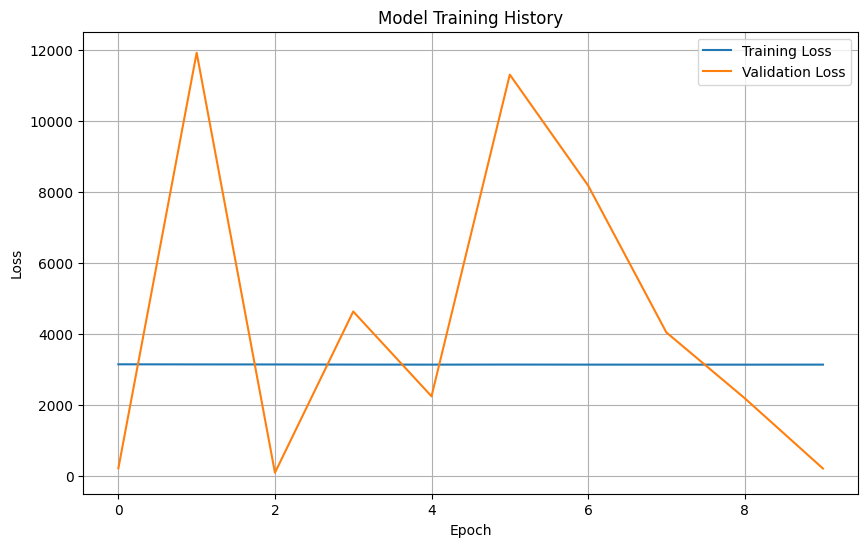

In [14]:
# Create and train the model
print("\nCreating and training the model...")
model = create_autoencoder(input_dim=X_train.shape[1])
print("\nModel Summary:")
model.summary()

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', 
                  patience=10, 
                  restore_best_weights=True,
                  verbose=1),
    ReduceLROnPlateau(monitor='val_loss', 
                      factor=0.5, 
                      patience=5, 
                      min_lr=1e-6,
                      verbose=1)
]

# Train the model with larger batch size for CPU
history = model.fit(
    X_train, X_train,
    epochs=10,
    batch_size=256,  # Increased batch size for CPU
    validation_data=(X_test, X_test),
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Calculating reconstruction errors...
65791/65791 ━━━━━━━━━━━━━━━━━━━━ 49s 739us/step
16448/16448 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


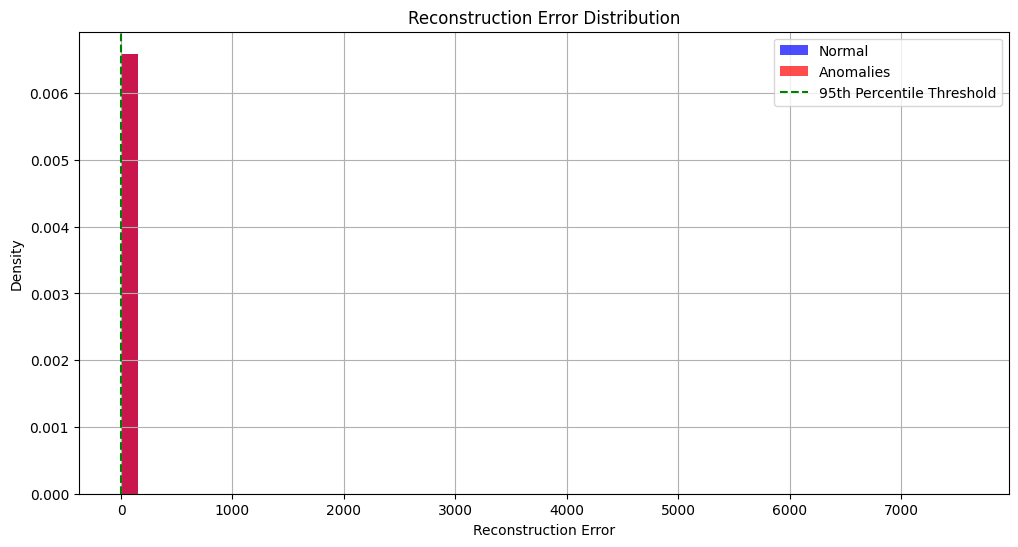


Anomaly Detection Results:
Total samples in test set: 4210603
Number of anomalies detected: 211599
Anomaly percentage: 5.03%

Example anomalous rides (first 5):
   ride_duration  ride_distance_km  speed_kmh  start_hour  start_dayofweek  \
0      41.883333          9.000053  12.893033         9.0              4.0   
1      49.350000          7.899795   9.604614         4.0              6.0   
2      36.116667          9.700349  16.115023        13.0              6.0   
3      18.766667          5.800664  18.545640        23.0              5.0   
4     210.266667          3.610781   1.030343        10.0              3.0   

   distance_duration_ratio  
0                 0.214884  
1                 0.160077  
2                 0.268584  
3                 0.309094  
4                 0.017172  


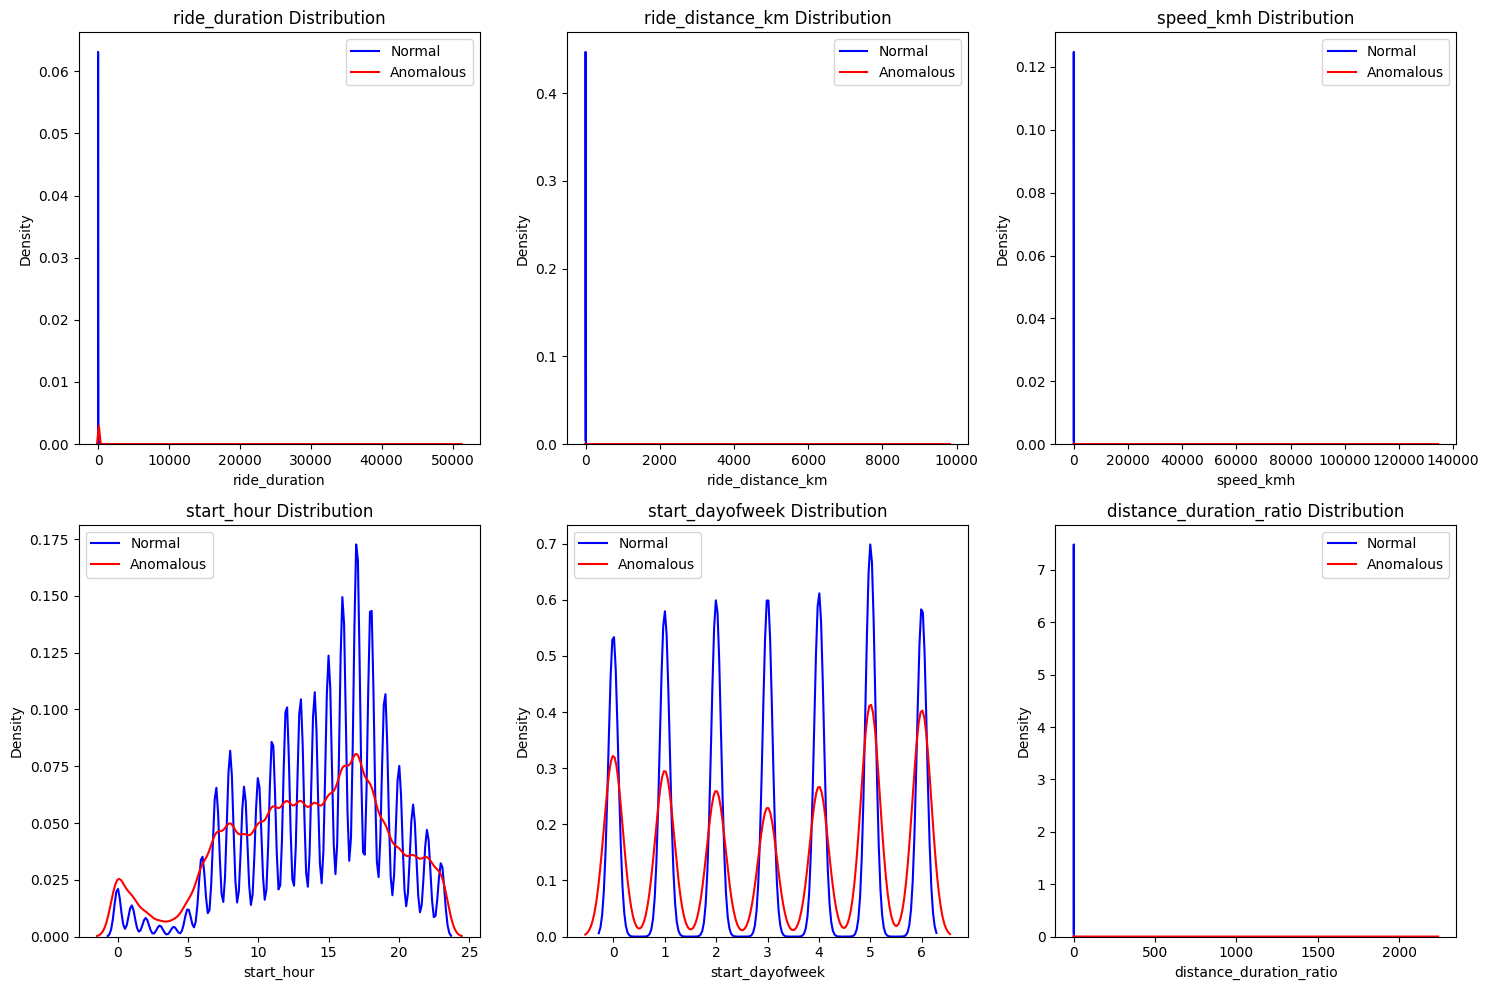

In [15]:
# Calculate reconstruction errors
print("\nCalculating reconstruction errors...")
train_reconstructed = model.predict(X_train, batch_size=256)
train_error = np.mean(np.abs(train_reconstructed - X_train), axis=1)

test_reconstructed = model.predict(X_test, batch_size=256)
test_error = np.mean(np.abs(test_reconstructed - X_test), axis=1)

# Set threshold and detect anomalies
threshold_percentile = 95  # Lowered threshold to detect more anomalies
threshold = np.percentile(train_error, threshold_percentile)
anomalies = test_error > threshold

# Visualize reconstruction error distribution
plt.figure(figsize=(12, 6))
plt.hist(test_error, bins=50, density=True, alpha=0.7, color='blue', label='Normal')
plt.hist(test_error[anomalies], bins=50, density=True, alpha=0.7, color='red', label='Anomalies')
plt.axvline(threshold, color='green', linestyle='--', label=f'{threshold_percentile}th Percentile Threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# Print anomaly detection results
print(f"\nAnomaly Detection Results:")
print(f"Total samples in test set: {len(X_test)}")
print(f"Number of anomalies detected: {np.sum(anomalies)}")
print(f"Anomaly percentage: {(np.sum(anomalies)/len(anomalies))*100:.2f}%")

# Show example anomalies
anomalous_samples = pd.DataFrame(
    scaler.inverse_transform(X_test[anomalies]),
    columns=features
)
print("\nExample anomalous rides (first 5):")
print(anomalous_samples.head())

# Additional improvements for anomaly detection
# Compare feature distributions for normal vs anomalous rides
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    normal_data = scaler.inverse_transform(X_test[~anomalies])
    anomaly_data = scaler.inverse_transform(X_test[anomalies])
    sns.kdeplot(data=pd.DataFrame(normal_data, columns=features)[feature], 
                label='Normal', color='blue')
    sns.kdeplot(data=pd.DataFrame(anomaly_data, columns=features)[feature], 
                label='Anomalous', color='red')
    plt.title(f'{feature} Distribution')
    plt.legend()
plt.tight_layout()
plt.show()